/media/e80601/20T/liaqat/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire_10.jpg


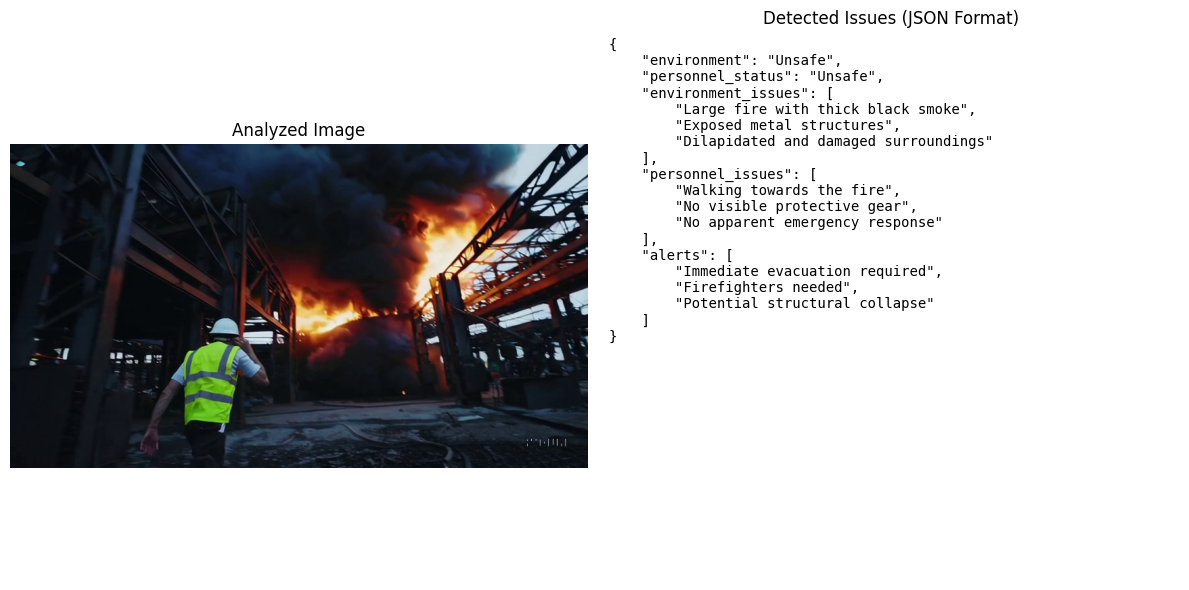

Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire1_145.jpg


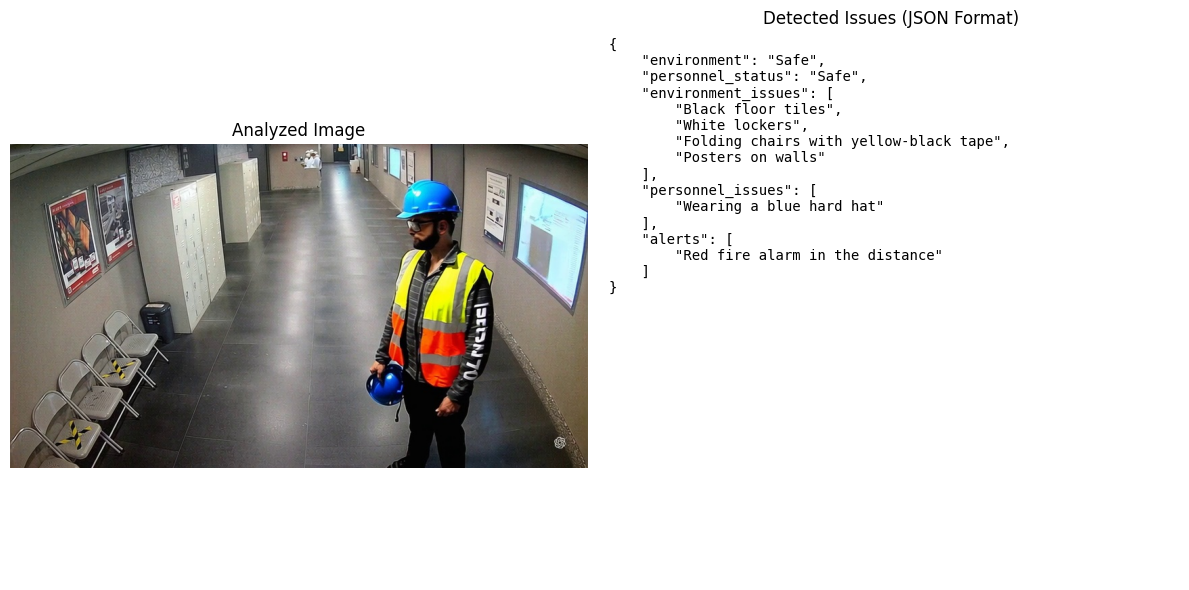

Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire1_24.jpg


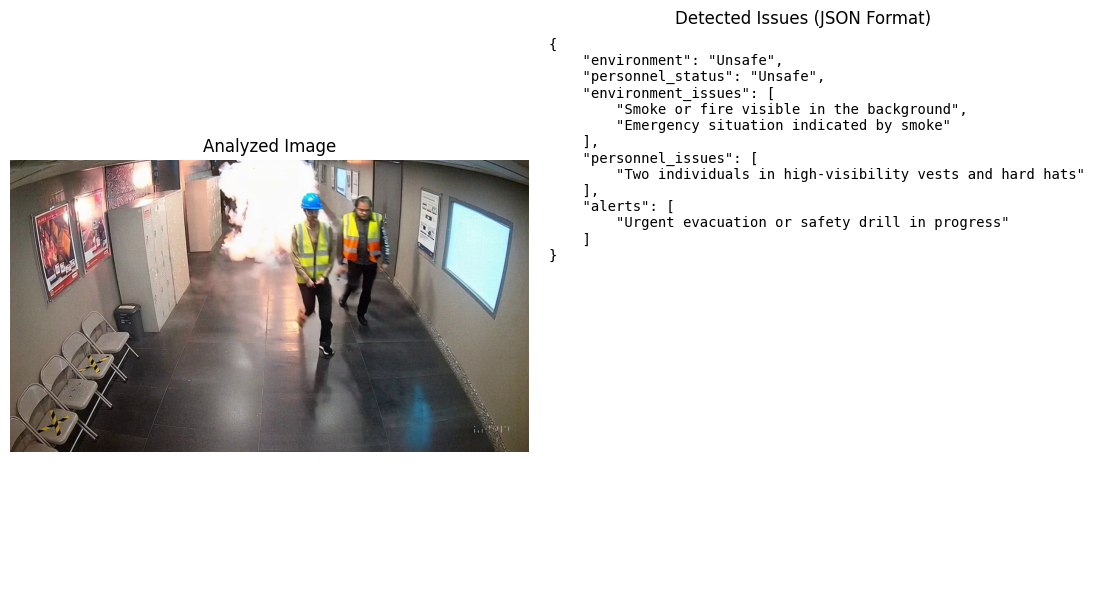

Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire1_2.jpg


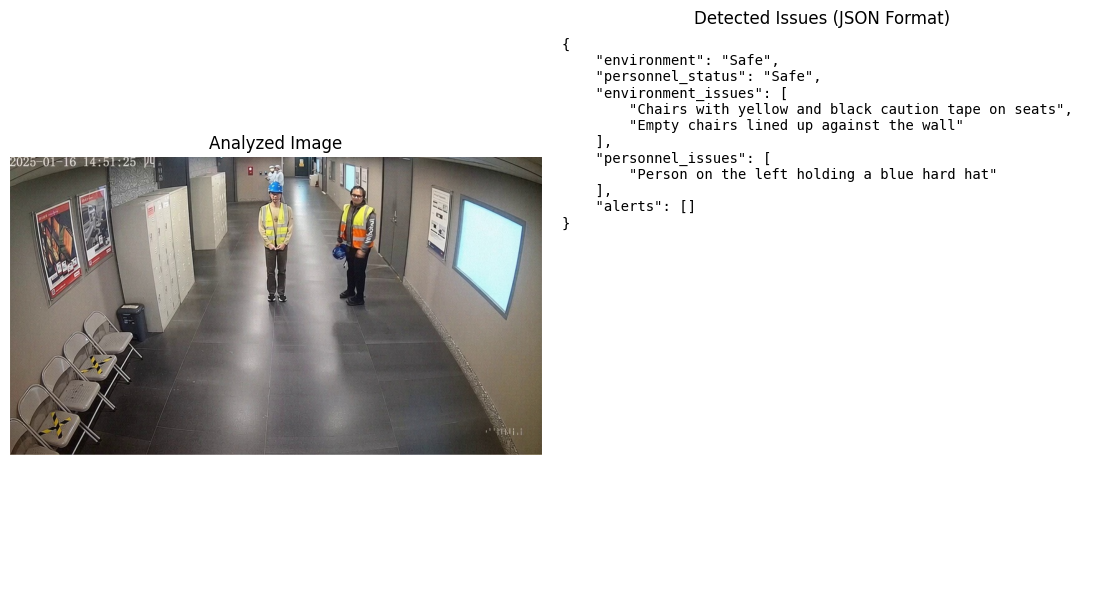

Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire1_58.jpg


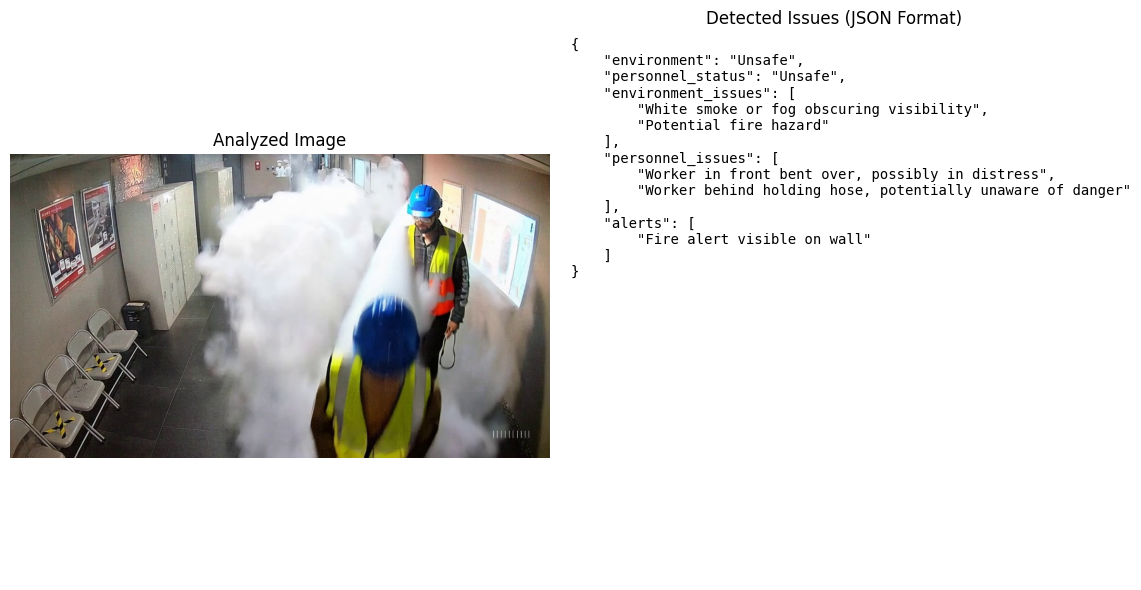

Processing: /media/e80601/20T/liaqat/data/20250305_Factory_Fire_107.jpg


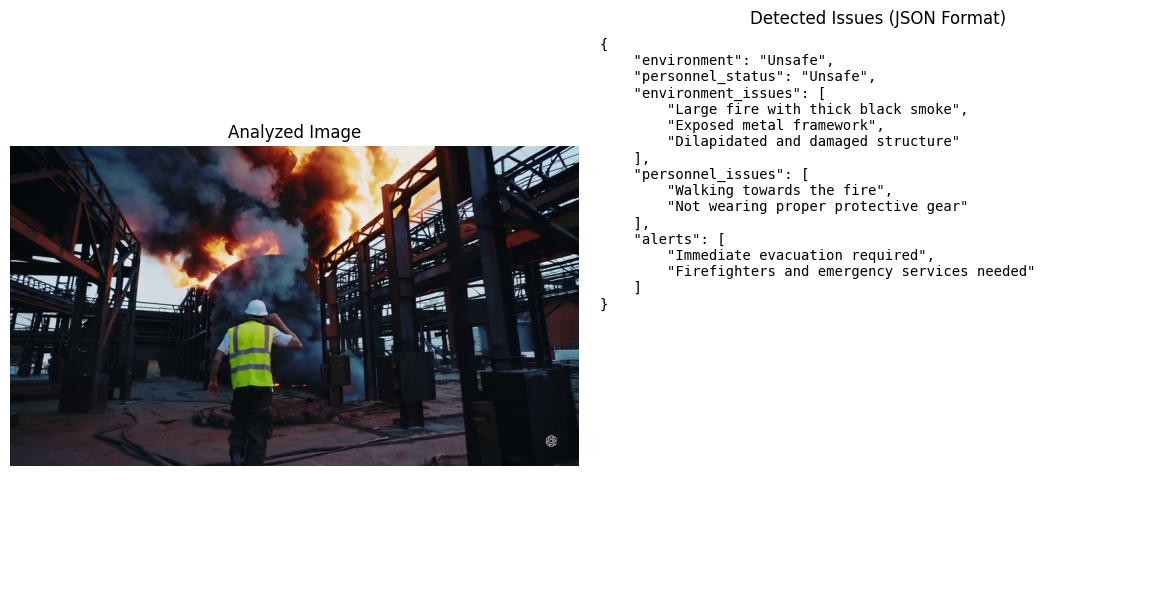

Analysis completed. Results saved to safety_analysis_results.json


In [ ]:
import torch
from PIL import Image
import json
import os
import re
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "AIDC-AI/Ovis2-4B",
    torch_dtype=torch.bfloat16,
    multimodal_max_length=32768,
    trust_remote_code=True
).cuda()

text_tokenizer = model.get_text_tokenizer()
visual_tokenizer = model.get_visual_tokenizer()

image_folder = "/media/e80601/20T/liaqat/data/"
output_json_path = "safety_analysis_results.json"

if not os.path.exists(image_folder):
    print("Error: The specified image folder does not exist.")
    exit()


image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith((".jpg", ".jpeg"))]

if not image_files:
    print("No images found in the specified folder.")
    exit()

#prompt 
prompt_template = """<image>
Analyze the image and provide safety information in JSON format:
1. "environment": "Safe" or "Unsafe"
2. "personnel_status": "Safe" or "Unsafe"
3. "environment_issues": List any specific issues.
4. "personnel_issues": List any specific issues.
5. "alerts": Mention any urgent alerts."""


results = {}

# image
for image_path in image_files:
    print(f"Processing: {image_path}")

    images = [Image.open(image_path)]
    max_partition = 9
    query = f"{prompt_template}"

    # Preprocess inputs
    prompt, input_ids, pixel_values = model.preprocess_inputs(query, images, max_partition=max_partition)
    attention_mask = torch.ne(input_ids, text_tokenizer.pad_token_id)
    input_ids = input_ids.unsqueeze(0).to(device=model.device)
    attention_mask = attention_mask.unsqueeze(0).to(device=model.device)

    if pixel_values is not None:
        pixel_values = pixel_values.to(dtype=visual_tokenizer.dtype, device=visual_tokenizer.device)
    pixel_values = [pixel_values]

    # output
    with torch.inference_mode():
        gen_kwargs = dict(
            max_new_tokens=1024,
            do_sample=False,
            eos_token_id=model.generation_config.eos_token_id,
            pad_token_id=text_tokenizer.pad_token_id,
            use_cache=True
        )
        output_ids = model.generate(input_ids, pixel_values=pixel_values, attention_mask=attention_mask, **gen_kwargs)[0]
        output_text = text_tokenizer.decode(output_ids, skip_special_tokens=True)

    # Extract JSON from output_text
    json_match = re.search(r'\{.*\}', output_text, re.DOTALL)
    if json_match:
        json_str = json_match.group(0)
        try:
            result_json = json.loads(json_str)
        except json.JSONDecodeError:
            print("Failed to parse JSON for:", image_path)
            result_json = {"raw_output": output_text}
    else:
        result_json = {"raw_output": output_text}

    # result for the image
    results[image_path] = result_json

    # image alongside JSON output
    plt.figure(figsize=(12, 6))
    
    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(images[0])
    plt.axis('off')
    plt.title("Analyzed Image")

    # Show JSON output
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title("Detected Issues (JSON Format)")
    
    # JSON for display
    json_display = json.dumps(result_json, indent=4)
    plt.text(0.01, 0.99, json_display, fontsize=10, va='top', wrap=True, family='monospace')

    plt.tight_layout()
    plt.show()


# Save 
with open(output_json_path, "w", encoding="utf-8") as json_file:
    json.dump(results, json_file, indent=4)

print(f"Analysis completed. Results saved to {output_json_path}")
